# Neural Network Quantum State - Simple Harmonic Oscillator

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Assigning the GPU as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
#Defining the space grid x
x_min = -10.0
x_max = 10.0
N = 20001
x = torch.linspace(x_min,x_max,N).to(device)
x.requires_grad = True
#Converting x into N x 1 tensor.
x = x.reshape(-1,1)
x

tensor([[-10.0000],
        [ -9.9990],
        [ -9.9980],
        ...,
        [  9.9980],
        [  9.9990],
        [ 10.0000]], device='cuda:0', grad_fn=<ViewBackward0>)

In [8]:
#Finding the infinitesimal difference between two consective x grid points. 
dx = x[1]-x[0]
dx = dx.item()
dx #We will use it as the dx for doing integrations later.

0.0010004043579101562

## Defining the Neural Network for approximating the quantum states.

In [11]:
class NNQS(nn.Module):
    def __init__(self):
        super(NNQS, self).__init__()
        self.fc1_u = nn.Linear(1, 50)
        self.fc2_u = nn.Linear(50, 50)
        self.fc3_u = nn.Linear(50, 1)
        
    def forward(self, x):
        u = F.softplus(self.fc1_u(x))
        u = F.softplus(self.fc2_u(u))
        u = self.fc3_u(u)
        return u

If we are loading an already trained model, we will use this next cell of code to load the trained model.

In [14]:
# This block of code loads a pretrained model if we have already trained it and saved it in "nnqs_ground_state.pth".

# Initialize the model
model = NNQS().to(device)

#Here we can load a pretrained model (that I have trained earlier) if we want or we can leave it and train it ourselves again.
model_save_path = "nnqs_ground_state.pth"

# Load the state dictionary
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (optional, for inference)
model.eval()

print("Model parameters loaded successfully.")

Model parameters loaded successfully.


C:\Users\yaman\AppData\Local\Temp\ipykernel_8352\2143802673.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


If we are training the model for the first time, we skip the above cell of code continue from here.

In [ ]:
#Initialize the model with arbitrary parameters which will be trained later.
model = NNQS().to(device)

Now we define the loss function i.e. the energy function which calculates the expectation value of energy for the quantum states approximated by the neural network. We are using the variational approximation of quantum mechanics to obtain the ground state.

In [16]:
w = 2.0
def energy(x,model): # This is our main loss function which is calculating the expected energy of the neural network state.
    u = model(x)
    u1 = u.reshape(-1)
    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:,0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    return torch.sum((-u_xx*u1+(w**2)*(x1**2)*(u1**2)))*dx

In [18]:
def normalization(x,model): # This will be a regularization function which ensures that the wavefunction will be normalized to 1.
    u = model(x)
    return 1000*((torch.sum(u**2)*dx- torch.tensor(1.0))**2)

In [20]:
eta = 0.001
optimizer = optim.Adam(list(model.parameters()), lr=eta)

In [35]:
def train_model(model,x,eta,optimizer):
    for epoch in range(10000):
        E_loss = HpsiH(x,model)
        norm_loss = normalization(x,model)            
        optimizer.zero_grad()
        L_total = E_loss + norm_loss
        
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        
        if epoch%100==99:
            print(f"epochs:{epoch+1} , Loss:{L_total}")
    return model

trained_model = train_model(model,x,eta,optimizer)

epochs:100 , Loss:2.012955665588379
epochs:200 , Loss:2.0128068923950195
epochs:300 , Loss:2.0126166343688965
epochs:400 , Loss:2.012371063232422
epochs:500 , Loss:2.0120749473571777
epochs:600 , Loss:2.01175856590271
epochs:700 , Loss:2.0114309787750244
epochs:800 , Loss:2.011054515838623
epochs:900 , Loss:2.0103516578674316
epochs:1000 , Loss:2.009632110595703
epochs:1100 , Loss:2.0090911388397217
epochs:1200 , Loss:2.008629083633423
epochs:1300 , Loss:2.0129950046539307
epochs:1400 , Loss:2.009310722351074
epochs:1500 , Loss:2.0076308250427246
epochs:1600 , Loss:2.0073015689849854
epochs:1700 , Loss:2.0083906650543213
epochs:1800 , Loss:2.006895065307617
epochs:1900 , Loss:2.006544589996338
epochs:2000 , Loss:2.012016534805298
epochs:2100 , Loss:2.0061042308807373
epochs:2200 , Loss:2.0096585750579834
epochs:2300 , Loss:2.005725622177124
epochs:2400 , Loss:2.0055243968963623
epochs:2500 , Loss:2.005396842956543
epochs:2600 , Loss:2.005192756652832
epochs:2700 , Loss:2.01081514358520

In [22]:
u_pred = model(x).reshape(-1)

In [23]:
u_pred = model(x).reshape(-1)
# Assuming u_pred is already converted to a numpy array
u_plot = u_pred.detach().cpu().numpy()

# Create x_array
x_array = np.linspace(x_min, x_max, N)

Let us compare the actual solution with the predicted solution from neural network.

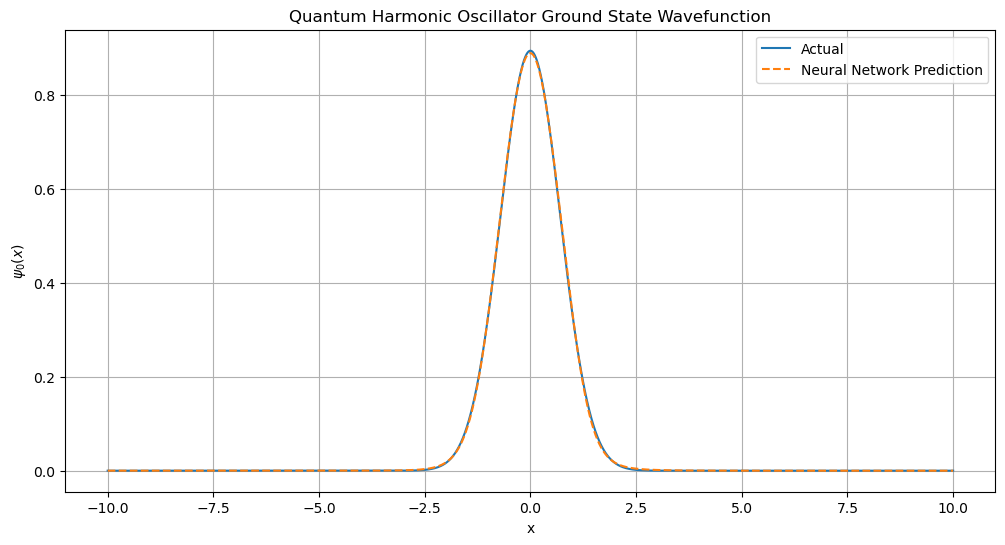

<Figure size 640x480 with 0 Axes>

In [313]:
import numpy as np
from scipy.special import hermite, factorial

# Below is the function that calculates the exact n^th state of the Simple Harmonic Osciallator. For convention, n=0 is the ground state.
def psi_n(X, n, m, omega, hbar):
    """
    Calculate the wavefunction psi_n(x) for the quantum harmonic oscillator.

    Parameters:
    x : float or ndarray
        Position where the wavefunction is evaluated.
    n : int
        Quantum number (n = 0, 1, 2, ...).
    m : float
        Mass of the particle.
    omega : float
        Angular frequency of the oscillator.
    hbar : float
        Reduced Planck's constant.

    Returns:
    float or ndarray
        Value of the wavefunction at position x.
    """
    # Pre-factor
    norm_factor = (1 / np.sqrt(2**n * factorial(n))) * (m * omega / (np.pi * hbar))**0.25

    # Exponential term
    exp_factor = np.exp(-m * omega * X**2 / (2 * hbar))

    # Hermite polynomial
    H_n = hermite(n)
    hermite_term = H_n(np.sqrt(m * omega / hbar) * X)

    # Wavefunction
    psi = norm_factor * exp_factor * hermite_term

    return psi

# Example usage
m = 1.0      # Mass of the particle
omega = 2.0  # Angular frequency
hbar = 1.0   # Reduced Planck's constant
X = np.linspace(-10, 10, 20001)  # Position array
n = 0        # Quantum number

# Calculate psi_n(x) for the given n
wavefunction = psi_n(X, n, m, omega, hbar)

# Optional: Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(X, wavefunction, label="Actual")
plt.plot(X, u_plot, label="Neural Network Prediction", linestyle='--')

plt.title("Quantum Harmonic Oscillator Ground State Wavefunction")
plt.xlabel("x")
plt.ylabel(f"$\psi_{n}(x)$")
plt.legend()
plt.grid()
plt.show()
plt.savefig("quantum_harmonic_oscillator_ground_state.png", dpi=300, bbox_inches='tight')


In [37]:
#After training, we should save the model parameters.
# Specify the path to save the model parameters
model_save_path = "nnqs_ground_state.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model parameters saved to {model_save_path}")


Model parameters saved to nnqs_ground_state.pth


In [32]:
u_ground = model(x)
u_grad = torch.autograd.grad(u_ground, x, grad_outputs=torch.ones_like(u_ground), create_graph=True)[0]
u_gradgrad = torch.autograd.grad(u_grad, x, grad_outputs=torch.ones_like(u_ground), create_graph=True)[0]
u_ground_xx = u_gradgrad[:,0]
u_ground_xx

tensor([-1.6717e-06, -1.6715e-06, -1.6714e-06,  ...,  2.5784e-08,
         2.5739e-08,  2.5694e-08], device='cuda:0', grad_fn=<SelectBackward0>)

Let's store the ground state in u_g thus obtaine and detach it since we won't need to train it for subsequent use.

In [35]:
u_g = u_ground.clone().detach()
u_g_xx = u_ground_xx.clone().detach()

# 1st Excited State

In [37]:
#Initialize a model for the first excited state
model_excited = NNQS().to(device)

If we are loading an already trained model, we will use this next cell of code to load the trained model. We will skip it otherwise.

In [40]:
# Initialize the model
model_excited = NNQS().to(device)

#Here we can load a pretrained model (that I have trained earlier) if we want or we can leave it and train it ourselves again.
model_save_path = "nnqs_excited1_state.pth"

# Load the state dictionary
model_excited.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (optional, for inference)
model_excited.eval()

print("Model parameters loaded successfully.")

Model parameters loaded successfully.


C:\Users\yaman\AppData\Local\Temp\ipykernel_8352\2589403285.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_excited.load_state_dict(torch.load(model_save_path))


If we use the variational principle directly, we will get the ground state back. However, we can use Grahm-Schmidt orthogonalization to create a state orthogonal to the ground state. Since Quantum Harmonic oscillator has a unique ground state, applying the variational principle on the state orthogonal to ground state will give us the next lowest eigenstate i.e. the first excited state.

In [43]:
#This function is again our loss function and calculates the expected energy of the state after it is made orthogonal to the ground state.
w = 2.0
def energy_excited1(x,model_excited): 
    u_exc_crude = model_excited(x)
    cosine = ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2))) # This is the component of u_g that needs to be subtracted from u_exc_crude.
    u_exc = u_exc_crude - cosine*u_g  # This is doing the Grahm-Schmidt orthogonalization.
    grads = torch.autograd.grad(u_exc_crude, x, grad_outputs=torch.ones_like(u_exc_crude), create_graph=True)[0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u_exc_crude), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    u_xx_exc = u_xx - cosine*u_g_xx
    u_exc_shaped = u_exc.reshape(-1)
    return torch.sum((-u_xx_exc*u_exc_shaped+(w**2)*(x1**2)*(u_exc_shaped**2)))*dx

In [45]:
def normalize(x,model_excited): #This function ensures that the state after orthogonalization is normalized to 1.
    u_exc_crude = model_excited(x)
    cosine = ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2)))
    u_exc = u_exc_crude - cosine*u_g
    return 1000*((torch.sum(u_exc**2)*dx - torch.tensor(1.0))**2)

In [47]:
eta = 0.001
optimizer2 = optim.Adam(list(model_excited.parameters()), lr=eta)

In [ ]:
for epoch in range(10000):
    E_loss = energy_excited1(x,model_excited)
    norm_loss = normalize(x,model_excited)         
    optimizer2.zero_grad()
    Loss_total = E_loss + norm_loss
    #Loss_total = norm_loss

    # Step 3: Backpropagate to compute gradients
    Loss_total.backward()
    
    # Step 4: Perform the gradient descent step
    optimizer2.step()
    
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{Loss_total}")

In [49]:
u_exc_crude = model_excited(x)
u_exc = u_exc_crude - ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2)))*u_ground
torch.sum(u_exc**2)*dx
x1 = x.reshape(-1)

In [51]:
energy_excited1(x,model_excited)/(torch.sum(u_exc**2)*dx)

tensor(6.0013, device='cuda:0', grad_fn=<DivBackward0>)

In [53]:
# Assuming u_pred is already converted to a numpy array
u_plot_excited = u_exc.reshape(-1).clone().detach().cpu().numpy()

# Create x_array
x_array = np.linspace(x_min, x_max, N)


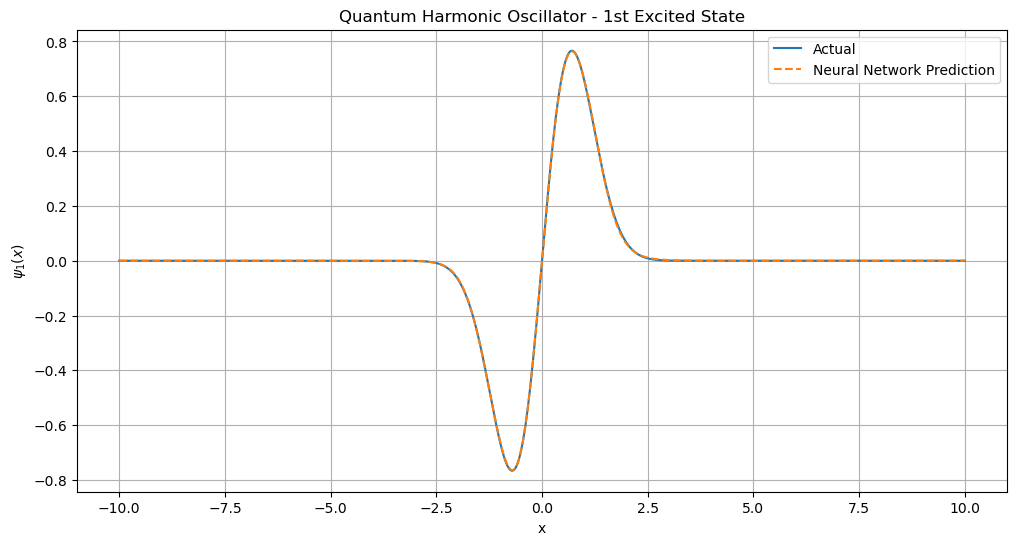

<Figure size 640x480 with 0 Axes>

In [315]:
n = 1        # Quantum number

# Calculate psi_n(x) for the given n
wavefunction_1 = psi_n(X, n, m, omega, hbar)

# Optional: Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(X, wavefunction_1, label="Actual")
plt.plot(X, u_plot_excited, label="Neural Network Prediction",linestyle='--')

plt.title("Quantum Harmonic Oscillator - 1st Excited State")
plt.xlabel("x")
plt.ylabel(f"$\psi_{n}(x)$")
plt.legend()
plt.grid()
plt.show()
plt.savefig("quantum_harmonic_oscillator_excited1_state.png", dpi=300, bbox_inches='tight')


In [84]:
#After training, we should save the model parameters.
# Specify the path to save the model parameters
model_save_path_excited1 = "nnqs_excited1_state.pth"

# Save the model's state dictionary
torch.save(model_excited.state_dict(), model_save_path_excited1)

print(f"Model parameters saved to {model_save_path_excited1}")


Model parameters saved to nnqs_excited1_state.pth


In [59]:
#After we train the model, we save the excited states by detaching them to the computational graph for subsequent use.
u_exc_crude = model_excited(x)
cosine1 = ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2)))
u_exc = u_exc_crude - cosine1*u_g
u_exc1 = u_exc.clone().detach() #This will be our saved first excited state for future use. This is detached since it doesn;t require training.

grads = torch.autograd.grad(u_exc_crude, x, grad_outputs=torch.ones_like(u_exc_crude), create_graph=True)[0]
u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u_exc_crude), create_graph=True)[0]
u_xx = u_x_grads[:,0]
x1 = x.reshape(-1)
u_xx_exc = u_xx - cosine1*u_g_xx
u_xx_exc1 = u_xx_exc.clone().detach()
u_exc1

tensor([[-1.1394e-04],
        [-1.1384e-04],
        [-1.1374e-04],
        ...,
        [-6.0553e-05],
        [-6.0647e-05],
        [-6.0741e-05]], device='cuda:0')

# 2nd Excited State

In [226]:
model_excited2 = NNQS().to(device)

In [228]:
w = 2.0
def energy_excited2(x,model_excited2): # This function calculates the expected value of energy of the second excited state.
    # We first project out the components of the ground and excited states from the neural network state and then apply the variational principle.
    u_exc2_crude = model_excited2(x)
    cosine20 = ((torch.sum(u_exc2_crude*u_g))/(torch.sum(u_g**2)))
    cosine21 = ((torch.sum(u_exc2_crude*u_exc1))/(torch.sum(u_exc1**2)))
    u_exc2 = u_exc2_crude - cosine20*u_g - cosine21*u_exc1
    grads = torch.autograd.grad(u_exc2_crude, x, grad_outputs=torch.ones_like(u_exc2_crude), create_graph=True)[0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u_exc2_crude), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    u_xx_exc2 = u_xx - cosine20*u_g_xx - cosine21*u_xx_exc1
    u_exc2_shaped = u_exc2.reshape(-1)
    return torch.sum((-u_xx_exc2*u_exc2_shaped+(w**2)*(x1**2)*(u_exc2_shaped**2)))*dx

In [230]:
def normalize2(x,model_excited2):
    u_exc2_crude = model_excited2(x)
    cosine20 = ((torch.sum(u_exc2_crude*u_g))/(torch.sum(u_g**2)))
    cosine21 = ((torch.sum(u_exc2_crude*u_exc1))/(torch.sum(u_exc1**2)))
    u_exc2 = u_exc2_crude - cosine20*u_g - cosine21*u_exc1
    return 10000*((torch.sum(u_exc2**2)*dx -  torch.tensor(1.0))**2)

In [293]:
eta = 0.00001
optimizer3 = optim.Adam(list(model_excited2.parameters()), lr=eta)

In [303]:
for epoch in range(50000):
    
    E_loss = energy_excited2(x,model_excited2)
    norm_loss = normalize2(x,model_excited2)         
    optimizer3.zero_grad()
    Loss_total = E_loss + norm_loss
    #Loss_total = norm_loss

    # Step 3: Backpropagate to compute gradients
    Loss_total.backward()
    
    # Step 4: Perform the gradient descent step
    optimizer3.step()
    
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{Loss_total}")

epochs:100 , Loss:10.016257286071777
epochs:200 , Loss:10.016220092773438
epochs:300 , Loss:10.01618480682373
epochs:400 , Loss:10.016148567199707
epochs:500 , Loss:10.01610279083252
epochs:600 , Loss:10.016064643859863
epochs:700 , Loss:10.016034126281738
epochs:800 , Loss:10.015983581542969
epochs:900 , Loss:10.015946388244629
epochs:1000 , Loss:10.015957832336426
epochs:1100 , Loss:10.015872955322266
epochs:1200 , Loss:10.015843391418457
epochs:1300 , Loss:10.015799522399902
epochs:1400 , Loss:10.015765190124512
epochs:1500 , Loss:10.015726089477539
epochs:1600 , Loss:10.015750885009766
epochs:1700 , Loss:10.015657424926758
epochs:1800 , Loss:10.01562213897705
epochs:1900 , Loss:10.01558780670166
epochs:2000 , Loss:10.015552520751953
epochs:2100 , Loss:10.015520095825195
epochs:2200 , Loss:10.015480041503906
epochs:2300 , Loss:10.015450477600098
epochs:2400 , Loss:10.015412330627441
epochs:2500 , Loss:10.015382766723633
epochs:2600 , Loss:10.015340805053711
epochs:2700 , Loss:10.015

In [305]:
u_exc2_crude = model_excited2(x)
cosine20 = ((torch.sum(u_exc2_crude*u_g))/(torch.sum(u_g**2)))
cosine21 = ((torch.sum(u_exc2_crude*u_exc1))/(torch.sum(u_exc1**2)))
u_exc2 = u_exc2_crude - cosine20*u_g - cosine21*u_exc1
u_exc2_shaped = u_exc2.reshape(-1)

In [307]:
torch.sum(u_exc2**2)*dx

tensor(0.9995, device='cuda:0', grad_fn=<MulBackward0>)

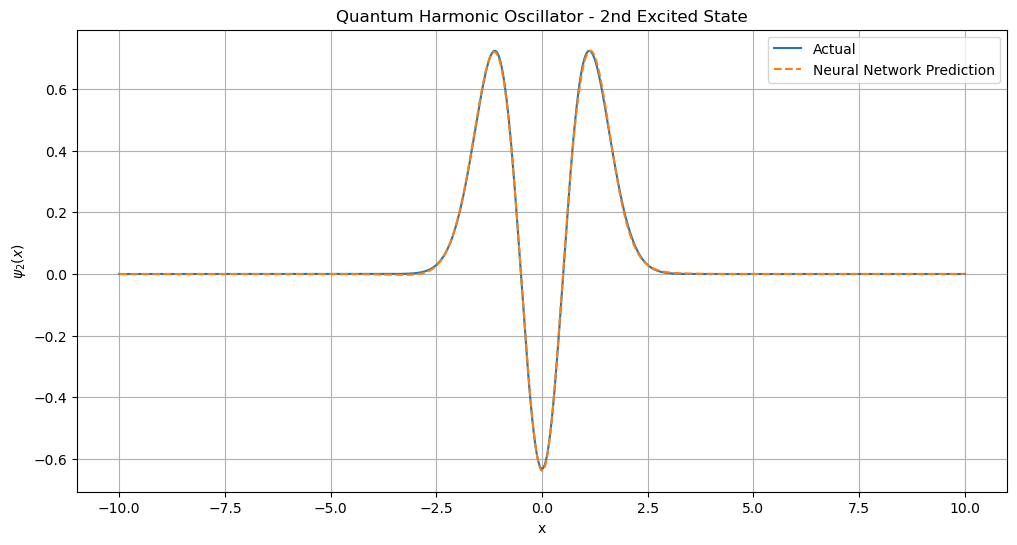

<Figure size 640x480 with 0 Axes>

In [317]:
X = np.linspace(-10, 10, 20001)  # Position array
n = 2        # Quantum number
u_plot_excited2 = u_exc2_shaped.clone().detach().cpu().numpy()
# Calculate psi_n(x) for the given n
wavefunction_2 = psi_n(X, n, m, omega, hbar)

# Optional: Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(X, wavefunction_2, label="Actual")
plt.plot(X, u_plot_excited2, label="Neural Network Prediction", linestyle='--')

plt.title("Quantum Harmonic Oscillator - 2nd Excited State")
plt.xlabel("x")
plt.ylabel(f"$\psi_{n}(x)$")
plt.legend()
plt.grid()
plt.show()
plt.savefig("quantum_harmonic_oscillator_excited2_state.png", dpi=300, bbox_inches='tight')


In [311]:
#After training, we should save the model parameters.
# Specify the path to save the model parameters
model_save_path2 = "nnqs_excited2_state.pth"

# Save the model's state dictionary
torch.save(model_excited2.state_dict(), model_save_path2)

print(f"Model parameters saved to {model_save_path2}")


Model parameters saved to nnqs_excited2_state.pth
